# Import Requirements

In [3]:

%load_ext autoreload

%autoreload 2

%matplotlib notebook

import os
import os.path as osp
import sys 
import time



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from data import *
from utils.augmentations import SSDAugmentation
from layers.modules import MultiBoxLoss
from architectures.FSSD_vgg import build_net

In [5]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision as tv
import torch.optim as optim



In [6]:
import torch.utils.data as data
import torchvision.datasets

import numpy as np
from PIL import Image
import argparse

from matplotlib import pyplot as plt
import pandas as pd
import cv2 
import pickle as pkl
import random
import tarfile
import collections
import math
import datetime
import pickle


In [7]:

from config_vgg16_ssd import *
import xml.etree.ElementTree as ET

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [9]:

def xavier(param):
    nn.init.xavier_uniform(param)


def weights_init(m):
    if isinstance(m, nn.Conv2d):
        xavier(m.weight.data)
        m.bias.data.zero_()


In [10]:
def plot(list_loss , fig, axes ):

    
    axes.clear()
    axes.set_title('plot loss')

    axes.plot(list_loss, label='training loss')
    axes.set_ylabel('Loss')
    axes.set_xlabel('iter')
    axes.legend()
    
    
    plt.tight_layout()
    fig.canvas.draw()


In [11]:
def train(device, resume=None , num_iters = 60000 ):
    
    #use voc config 
    
  
    
    cfg = voc
 
    # build net  
    ssd_net = build_net( cfg['min_dim'] ) 
    ssd_net.train() 
    dataset = VOCDetection(root=voc_root,  # both 2012 and 2007 for training 
                            transform=SSDAugmentation(cfg['min_dim'],
                             MEANS))
    
    
    if resume:
        print('Resuming training, loading previous training at ',resume)
        ssd_net.load_weights(resume) 
    else:
        vgg_weights = torch.load(basenet)
        print('Loading base network...')
        ssd_net.base.load_state_dict(vgg_weights)
        print('Initializing weights...')
        ssd_net.extras.apply(weights_init)
        ssd_net.loc.apply(weights_init)
        ssd_net.conf.apply(weights_init)
    
    net = ssd_net
    

    
    if device:
        net = torch.nn.DataParallel(ssd_net)
        torch.backends.cudnn.benchmark = True
        net = net.to(device)
        
    optimizer = optim.SGD(net.parameters(), lr, momentum, weight_decay)
    
    criterion = MultiBoxLoss(cfg['num_classes'], 0.5, True, 0, True, 3, 0.5,
                             False, torch.cuda.is_available())

    
    net.train()
    mode = 'train'
    

    loc_loss = 0
    conf_loss = 0
    epoch = 0
    print('Loading the dataset...')

    epoch_size = len(dataset) // batch_size
    print('Training SSD on: ',mode)

    step_index = 0

    #based on adapted code
    train_data_loader = data.DataLoader(dataset, batch_size=32, num_workers=4, shuffle=True,\
                               collate_fn=detection_collate,pin_memory=True)
    
    print("Images in the training set = " + str(len(dataset)))
    print("Images in a mini-batch = "+str(batch_size))
    print("mini-batches = " + str(len(train_data_loader)))
    
    
     # create batch iterator
    batch_iterator = iter(train_data_loader)
    print("STARTING - ITERATIONS")
    
    
    l_loss = []
    c_loss = []
    itr = []
    
    with open('trained_weights/vgg16_ssd_stats_SGD.pkl','rb') as f:
        l_loss, c_loss, itr = pickle.load(f)   
    fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(7, 6))
    
    
    start_itr = len(itr)   
    for iteration in range(start_itr , num_iters) : 
        if iteration != 0 and (iteration % epoch_size == 0):
            # reset epoch loss counters
            loc_loss = 0
            conf_loss = 0
            epoch += 1

        if iteration in cfg['lr_steps']:
            step_index += 1
            lr_dec = lr * (gamma ** (step_index))
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_dec

            
        ## load train data
        try:
            images, targets = next(batch_iterator)
        except StopIteration:
            batch_iterator = iter(train_data_loader)
            images, targets = next(batch_iterator)


        
        if device:
            images = images.cuda()
            targets = [ann.cuda() for ann in targets]
        else:
            images = images
            targets = [ann for ann in targets]
        
        # forward
        t0 = time.time()
        out = net(images)

        # backprop
        optimizer.zero_grad()

        loss_l, loss_c = criterion(out, targets)
        loss = loss_l + loss_c

        loss.backward()

        optimizer.step()

        l_loss.append(loss_l.data.item())
        c_loss.append(loss_c.data.item())
        
        t1 = time.time()
        loc_loss += loss_l.data.item()
        conf_loss += loss_c.data.item()
        
        itr.append(iteration)
        
        if iteration % 10 == 0:
            print('timer: %.4f sec.' % (t1 - t0))
            print('iter ' + repr(iteration) + ' || Loss: %.4f ||' % (loss.data.item()), end=' ')
            currentDT = datetime.datetime.now()
            print (currentDT.strftime("%H:%M:%S %p"))
            print("\n")
        
        
        if iteration != 0 and iteration % 10 == 0:
            print('Saving state, iter:', iteration)
            iter_name = math.ceil(iteration/100)*100
            if iteration % 100 == 0:
                torch.save(ssd_net.state_dict(), 'trained_weights/ssd_VGG16_VOC_pyramidal' + '.pth') #dump on the same
            with open('trained_weights/vgg16_ssd_stats_SGD.pkl','wb') as f:
                pkl.dump([l_loss, c_loss, itr], f)
            
          
            plot([l_loss[k]+c_loss[k] for k in range(len(l_loss))],fig,axes )
                

    torch.save(ssd_net.state_dict(),
               save_folder + data_set + '.pth') 

### 

In [12]:
!cat config_vgg16_ssd.py

#Initialize pointers
data_set = 'VOC'
dataset_root = '//datasets/home/12/312/vpotnuru/data/VOC0712/VOC2007/'
voc_root = '//datasets/home/12/312/vpotnuru/data/VOC0712/'
save_folder = 'trained_weights/'
eval_save_folder = 'eval/'
devkit_path = 'devkit_path/'
output_dir = "out/"

#Run related metaparameters

batch_size = 32
resume = None

#Optimization metaparameters
lr = 1e-3
momentum = 0.9
weight_decay = 5e-4
gamma = 0.1
    
confidence_threshold = 0.01
top_k = 5
cleanup = True

YEAR = '2012'
dataset_mean = (104, 117, 123)
set_type = 'train'

# models to start from , based on he problem 
trained_model = 'weights/ssd_pretrained.pth'
basenet = 'weights/vgg16_reducedfc.pth'


# Train resume 

In [ ]:
train(device, 'trained_weights/ssd_VGG16_VOC_pyramidal.pth' , 120000) #make sure to increase num of iterations to execute

# Plot 

<IPython.core.display.Javascript object>


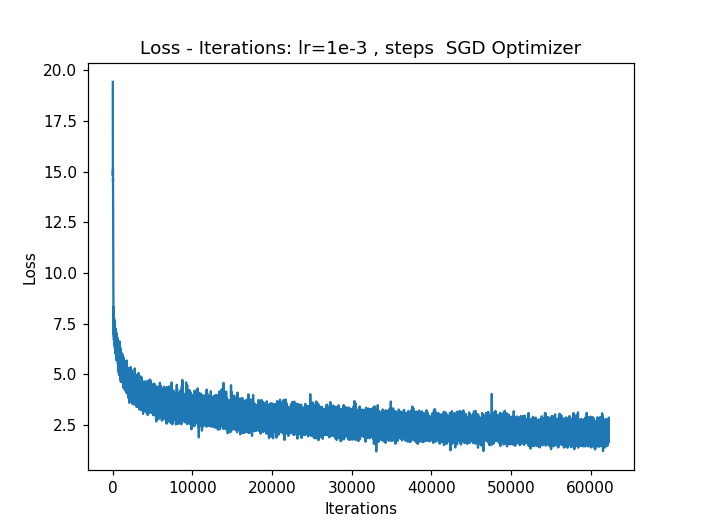

Text(0, 0.5, 'Loss')

In [14]:
with open('trained_weights/vgg16_ssd_stats_SGD.pkl','rb') as f:
    l_loss, c_loss, itr = pickle.load(f)

    

l_loss = np.asarray(l_loss)
c_loss = np.asarray(c_loss)
itr = np.asarray(itr)
plt.plot(itr,l_loss+c_loss)
plt.title('Loss - Iterations: lr=1e-3 , steps  SGD Optimizer')
plt.xlabel('Iterations')
plt.ylabel('Loss')